In [1]:
import numpy as np
from PIL import Image
from tensorface.embedding import embedding
from tensorface.const import FACE_PIC_SIZE
from tensorface.detection import img_to_np
import os
import matplotlib.pyplot as plt

Model filename: /Users/b.twardowski/pretrained_models/20180402-114759/20180402-114759.pb


## Read examples and perform embedding

In [2]:
EMBED_SIZE = 512
TRAIN_EXAMPLES_DIR = '../test/train_examples/'
TEST_EXAMPLES_DIR = '../test/test_examples/faces'

### Train examples

In [3]:
train_files = [f for f in os.listdir(TRAIN_EXAMPLES_DIR) if f.endswith('.png')]
print(train_files)

['train_StudBoy_160_10.png', 'train_StudGirl_160_10.png', 'train_Bartek_160_10.png', 'train_CoverGirl_160_10.png']


In [4]:
train_img = []
train_name = []
train_ex_e = []
train_ex_n = []

for f in  train_files:
    # for f in train_files:
    name, size, num = f.split(".")[0].split("_")[1:]
    img = Image.open(os.path.join(TRAIN_EXAMPLES_DIR, f))
    train_img.append(img)
    train_name.append(name)

    faces = []
    for i in range(int(num)):
        faces.append(img.crop((
            FACE_PIC_SIZE*i,
            0,
            FACE_PIC_SIZE*(i+1),
            FACE_PIC_SIZE
        )))

    for i, f in enumerate(faces):
        train_ex_e.append(embedding(img_to_np(f)))
        train_ex_n.append(name)

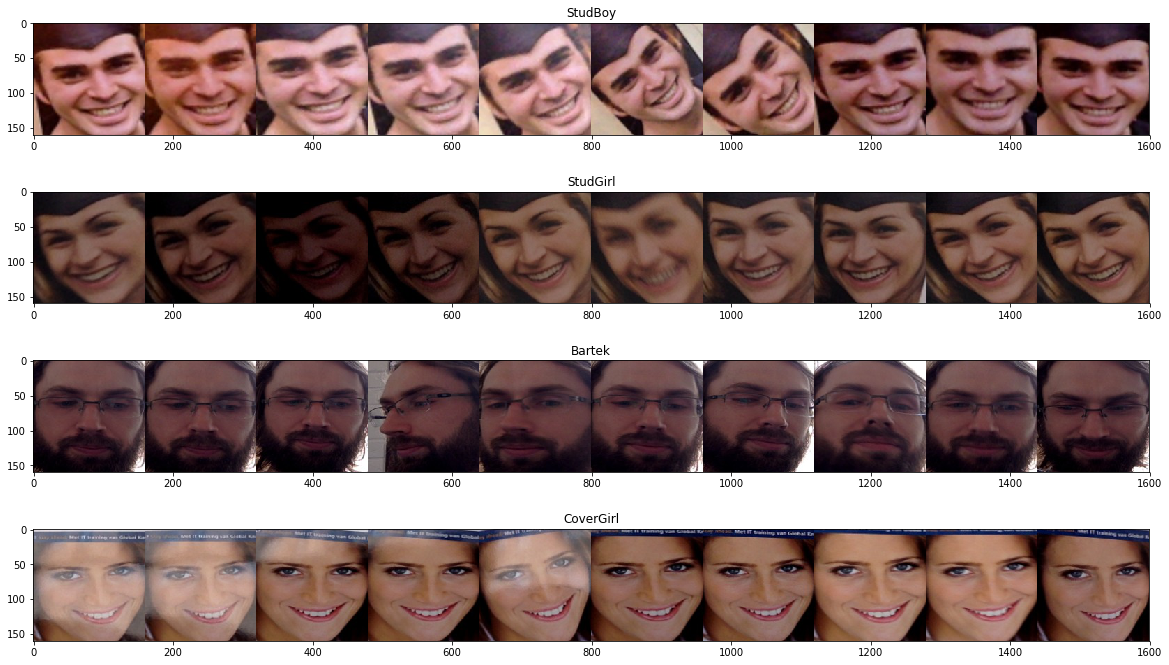

In [5]:
plt.figure(figsize=(20,15))
columns = 1
for i, image in enumerate(train_img):
    plt.subplot(len(train_img) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.title(train_name[i])

In [6]:
X_train = np.array(train_ex_e)
y_train = np.array(train_ex_n)
print(X_train.shape)
print(y_train.shape)

(40, 512)
(40,)


### Load test examples

In [7]:
test_files = [f for f in os.listdir(TEST_EXAMPLES_DIR) if f.endswith('.png')]
print(test_files)

['CoverGirl.png', 'StudBoy.png', 'unknown.png', 'unknown_1.png', 'Bartek.png', 'StudGirl.png']


In [8]:
test_img = []
test_e = []
test_n = []

for f in test_files:
    name = f.split(".")[0].split("_")[0]
    img = Image.open(os.path.join(TEST_EXAMPLES_DIR, f))
    test_e.append(embedding(img_to_np(img.resize((FACE_PIC_SIZE, FACE_PIC_SIZE), Image.BICUBIC))))
    test_n.append(name)
    test_img.append(img)

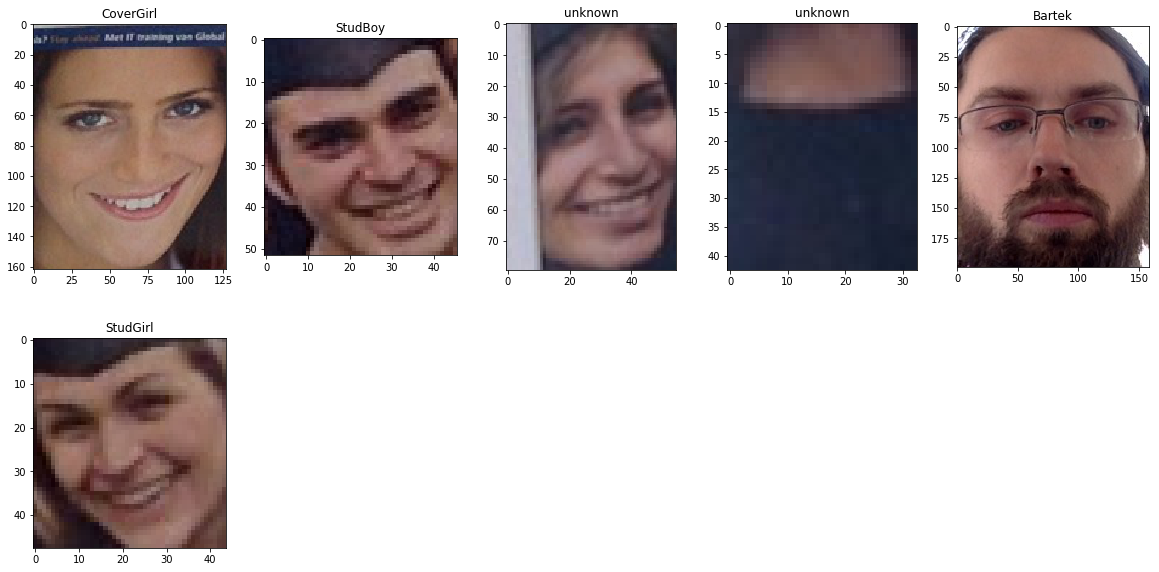

In [9]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(test_img):
    plt.subplot(len(test_img) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.title(test_n[i])

In [10]:
X_test = np.array(test_e)
y_test = np.array(test_n)
y_test

array(['CoverGirl', 'StudBoy', 'unknown', 'unknown', 'Bartek', 'StudGirl'],
      dtype='<U9')

## Baseline classification with kNN from sklearn

In [11]:
from sklearn import metrics

def knn_classifier(train_x, train_y):      
    from sklearn.neighbors import KNeighborsClassifier  
    model = KNeighborsClassifier()  
    model.fit(train_x, train_y)  
    return model  

classifier = knn_classifier 

model = classifier(X_train,y_train)  
predict = model.predict(X_test)  

accuracy = metrics.accuracy_score(y_test, predict)  
print ('accuracy: %.2f%%' % (100 * accuracy)  ) 
  

accuracy: 66.67%


In [12]:
print(model.classes_)
for y, y_pred in zip(test_n, model.predict_proba(X_test)):
    print(y_pred, 'True class:', y)

['Bartek' 'CoverGirl' 'StudBoy' 'StudGirl']
[0. 1. 0. 0.] True class: CoverGirl
[0. 0. 1. 0.] True class: StudBoy
[0. 1. 0. 0.] True class: unknown
[0.  0.  0.8 0.2] True class: unknown
[1. 0. 0. 0.] True class: Bartek
[0. 0. 0. 1.] True class: StudGirl


In [13]:
model.predict(X_test)

array(['CoverGirl', 'StudBoy', 'CoverGirl', 'StudBoy', 'Bartek',
       'StudGirl'], dtype='<U9')

In [14]:
from sklearn.externals import joblib

In [15]:
os.remove('knn_test.model')
joblib.dump(model, 'knn_test.model')

['knn_test.model']

In [16]:
model2 = joblib.load('knn_test.model')
predict = model2.predict(X_test) 
accuracy = metrics.accuracy_score(y_test, predict)  
print ('accuracy: %.2f%%' % (100 * accuracy)  ) 

accuracy: 66.67%


In [17]:
tx = X_test[0]

In [18]:
model2.predict(tx.reshape([1,-1]))

array(['CoverGirl'], dtype='<U9')

### how randowm is being classified?

['StudBoy']
[[0. 0. 1. 0.]]


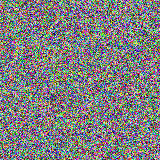

In [19]:
# r = (np.random.randn(FACE_PIC_SIZE, FACE_PIC_SIZE, 3) * 100) + 100
r = np.random.randint(0, 255, (FACE_PIC_SIZE, FACE_PIC_SIZE, 3), np.uint8)
e_test = embedding(r)
print(model2.predict(e_test.reshape([1,-1])))
print(model2.predict_proba(e_test.reshape([1,-1])))
Image.fromarray(r, 'RGB')

# kNN with Tensorflow

In [25]:
import tensorflow as tf

In [134]:
xtr=tf.placeholder(tf.float32,[None,EMBED_SIZE], name='X_train')
ytr=tf.placeholder(tf.float32,[len(y_train)], name='y_train') 
xte=tf.placeholder(tf.float32,[EMBED_SIZE], name='x_test') 

#K-near
K=5 #how many neighbors
nearest_neighbors=tf.Variable(tf.zeros([K]))

dist_threashold = tf.placeholder(tf.float32, shape=(), name="dist_threshold")

#model
distance = tf.reduce_sum(tf.abs(tf.subtract(xtr, xte)),axis=1)
values,indices=tf.nn.top_k(tf.negative(distance),k=K,sorted=False)
nn_dist = tf.negative(values)
valid_nn_num = tf.reduce_sum(tf.cast(nn_dist < dist_threashold, tf.float32))
# valid_nn_num = tf.reduce_sum((values > THRESHOLD).astype('float32'))

#a normal list to save
nn = []
for i in range(K):
    nn.append(ytr[indices[i]]) #taking the result indexes

#saving list in tensor variable
nearest_neighbors=nn
# this will return the unique neighbors the count will return the most common's index
y, idx, count = tf.unique_with_counts(nearest_neighbors)

pred = tf.slice(y, begin=[tf.argmax(count, 0)], size=tf.constant([1], dtype=tf.int64))[0]
# this is tricky count returns the number of repetation in each elements of y and then by begining from that and size begin 1
# it only returns that neighbors value : for example
# suppose a is array([11,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  4,  4,  4,  4]) so unique_with_counts of a will
#return y= (array([ 1,  2,  3,  4, 11]) count= array([3, 3, 2, 7, 1])) so argmax of count will be 3 which will be the
#index of 4 in y which is the hight number in a

In [135]:
idx_to_lbl = dict(enumerate(set(y_train)))
lbl_to_idx = {v:k for k,v in idx_to_lbl.items()}

In [136]:
y_train_idx = [lbl_to_idx[l] for l in y_train]

In [137]:
#setting accuracy as 0
accuracy=0

#initialize of all variables
init=tf.global_variables_initializer()

#start of tensor session
threshold = 14

result_dist_mistakes = []
result_dist_correct = []

with tf.Session() as sess:

    _y, _count, _pred, _dist = None, None, None, None
    accuracy = 0.0
    
    for i in range(X_test.shape[0]):
        _valid_nn_num, _y, _count, _pred, _nn_dist = sess.run([valid_nn_num, y, count, pred, nn_dist],feed_dict={xtr:X_train,ytr:y_train_idx,xte:X_test[i,:], dist_threashold: 15.0})
        y_hat = idx_to_lbl[int(_pred)]
        y_hat_prob = _y
        print("Test", i,"Prediction:", y_hat, " True Class:", y_test[i])
        print("Valid NN number:", _valid_nn_num)
        if y_hat == y_test[i]:
            accuracy += 1. / len(X_test)
            result_dist_correct.extend(_nn_dist)
        else:
            result_dist_mistakes.extend(_nn_dist)
    writer = tf.summary.FileWriter('./graphs',sess.graph)
    writer.close()
    # tensorboard --logdir="./graphs" --port 6006 in command promt to see the graph at localhost:6006
    print("Calculation completed ! ! ")
    print(K,"-th neighbors' Accuracy is:",accuracy)


Test 0 Prediction: CoverGirl  True Class: CoverGirl
Valid NN number: 5.0
Test 1 Prediction: StudBoy  True Class: StudBoy
Valid NN number: 5.0
Test 2 Prediction: CoverGirl  True Class: unknown
Valid NN number: 0.0
Test 3 Prediction: StudBoy  True Class: unknown
Valid NN number: 0.0
Test 4 Prediction: Bartek  True Class: Bartek
Valid NN number: 5.0
Test 5 Prediction: StudGirl  True Class: StudGirl
Valid NN number: 5.0
Calculation completed ! ! 
5 -th neighbors' Accuracy is: 0.6666666666666666


## Analyzing prediction

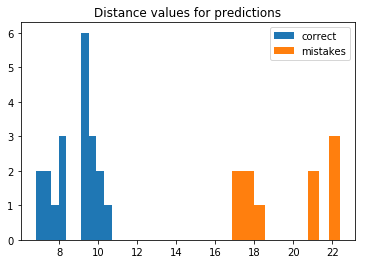

In [143]:
plt.hist(result_dist_correct, label='correct')
plt.hist(result_dist_mistakes, label='mistakes')
plt.title('Distance values for predictions')
plt.legend()

Mistakes are made only for "unknow" classes. So let's introduce the threshold for checking if we have valid NN. 

From the above plot -> threshold = 14.

In [146]:
from tensorface.recognition import UNKNOWN_CLASS
accuracy=0
with tf.Session() as sess:
    for i in range(X_test.shape[0]):
        _valid_nn_num, _pred = sess.run([valid_nn_num, pred],feed_dict={xtr:X_train,ytr:y_train_idx,xte:X_test[i,:], dist_threashold: 15.0})
        if _valid_nn_num == K:
            y_hat = idx_to_lbl[int(_pred)]
        else:
            y_hat = UNKNOWN_CLASS
        
        print("Test", i,"Prediction:", y_hat, " True Class:", y_test[i])
        print("Valid NN number:", _valid_nn_num)
        if y_hat == y_test[i]:
            accuracy += 1. / len(X_test)
            result_dist_correct.extend(_nn_dist)
        else:
            result_dist_mistakes.extend(_nn_dist)

    print(K,"-th neighbors' Accuracy is:",accuracy)


Test 0 Prediction: CoverGirl  True Class: CoverGirl
Valid NN number: 5.0
Test 1 Prediction: StudBoy  True Class: StudBoy
Valid NN number: 5.0
Test 2 Prediction: unknown  True Class: unknown
Valid NN number: 0.0
Test 3 Prediction: unknown  True Class: unknown
Valid NN number: 0.0
Test 4 Prediction: Bartek  True Class: Bartek
Valid NN number: 5.0
Test 5 Prediction: StudGirl  True Class: StudGirl
Valid NN number: 5.0
5 -th neighbors' Accuracy is: 0.9999999999999999


# This time far more better! 